<a href="https://colab.research.google.com/github/mikislin/CNE25/blob/main/notebooks/CNE_Class3_QAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## perform YOLO11 pose estimation using your webcam

In [ ]:
!uv pip install opencv-python-headless

Using Python 3.12.12 environment at: /usr
Audited 1 package in 275ms


In [ ]:
!uv pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.5/107.7 GB disk)


YOLO (You Only Look Once), a popular object detection and image segmentation model, was developed by Joseph Redmon and Ali Farhadi at the University of Washington

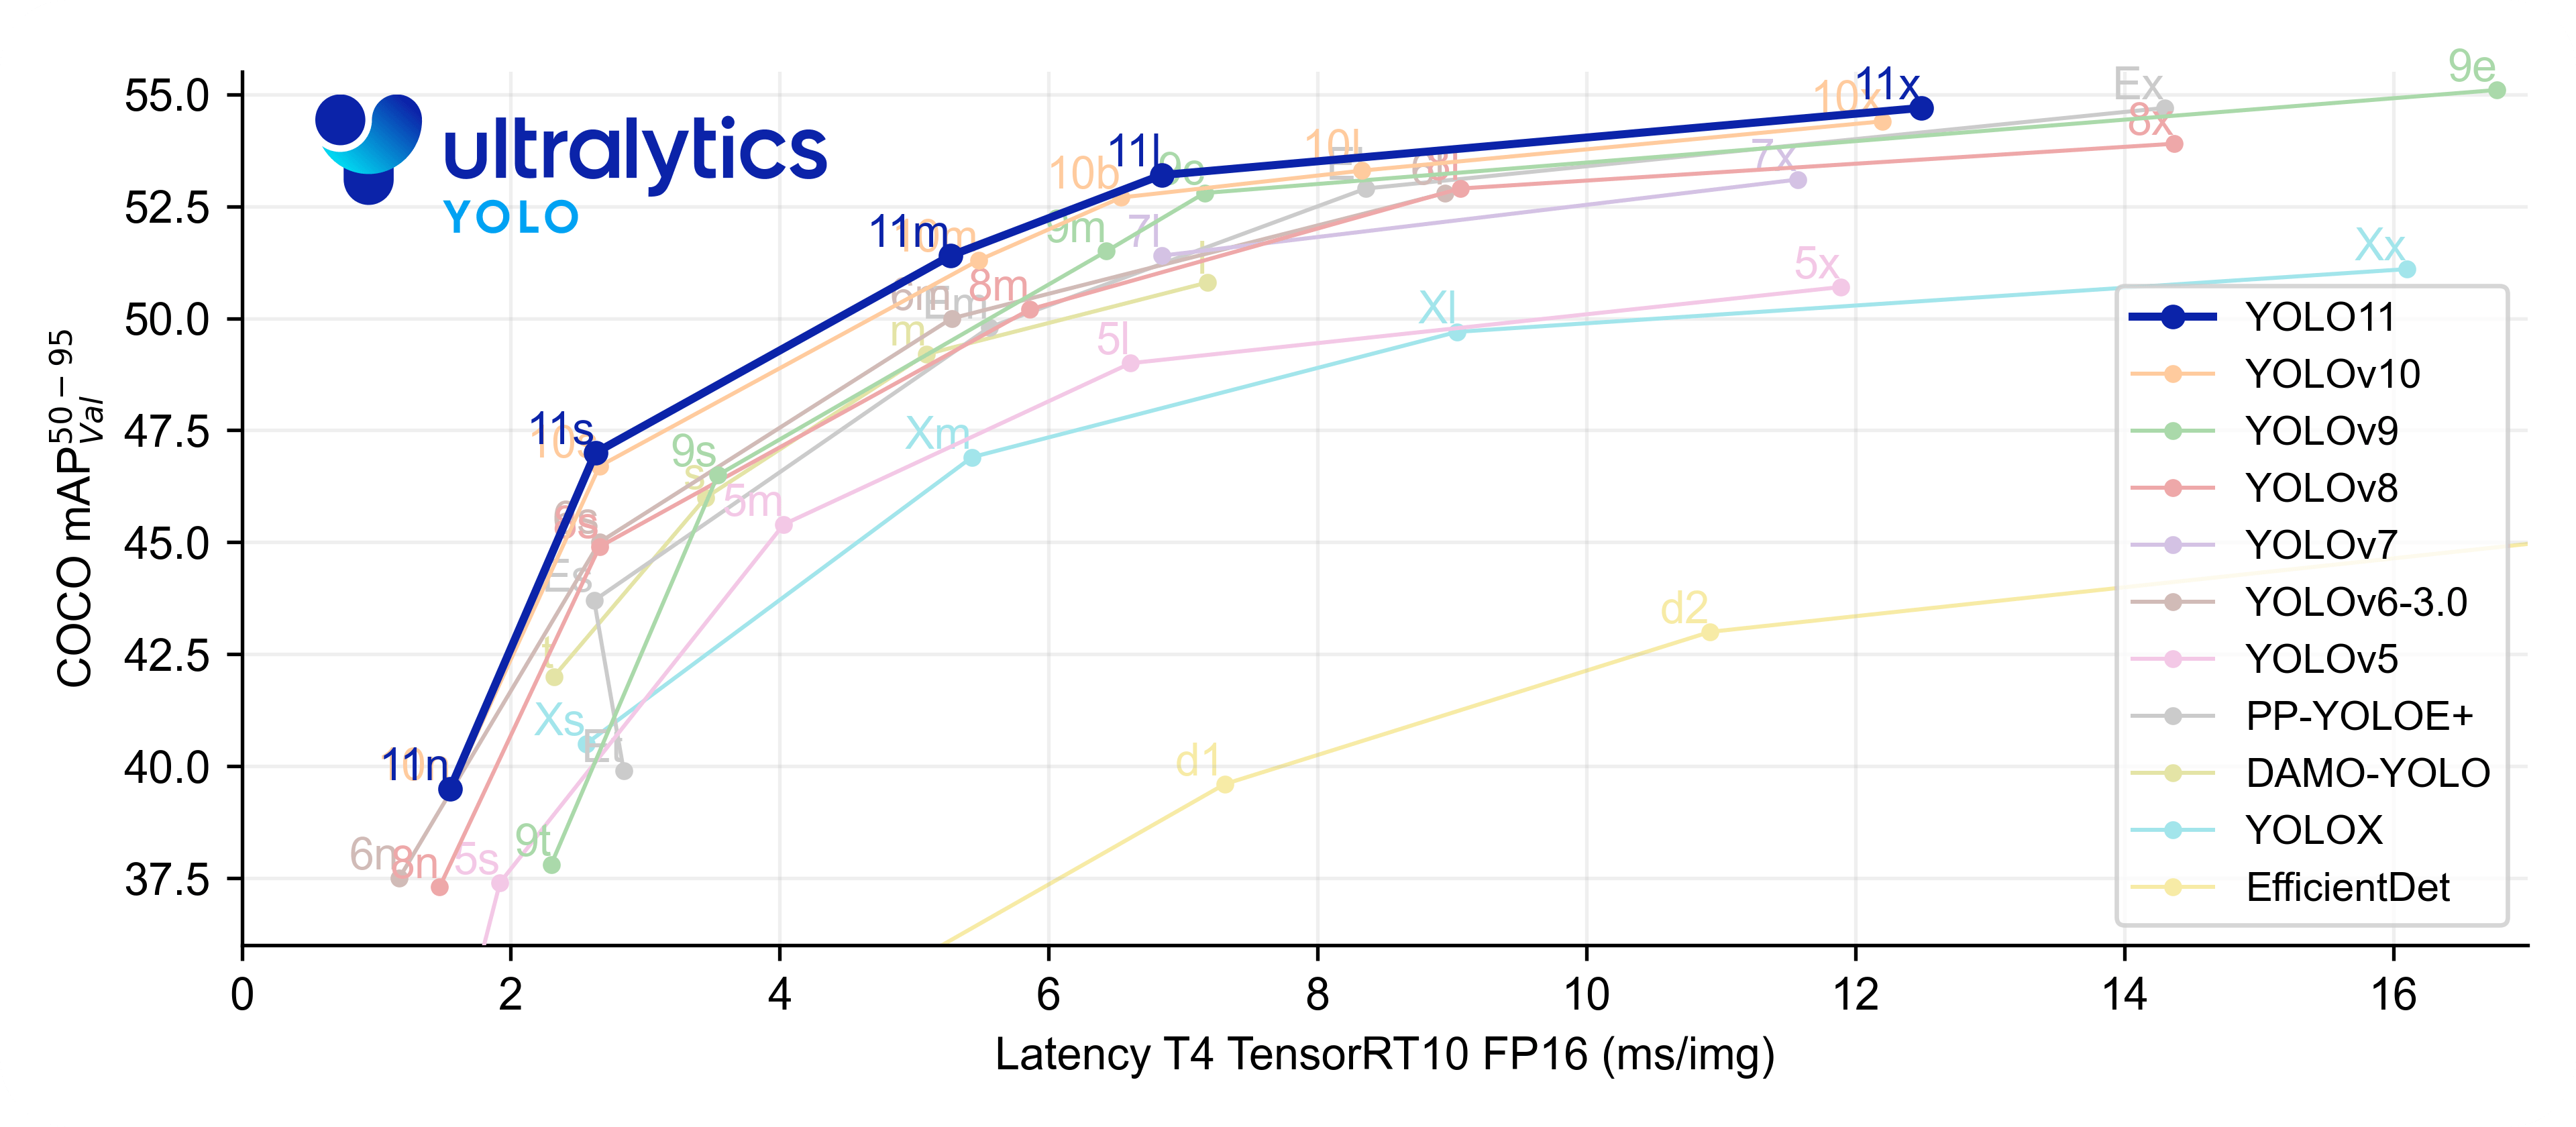

In [ ]:
# @title Load YOLO11n-pose
from ultralytics import YOLO

model = YOLO('yolo11n-pose.pt')  # load a pretrained YOLO pose model


### Define the Webcam Capture Function

This uses JavaScript to access your webcam and capture a frame when you click the button.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
        ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

### Run the Pose Estimation Loop

Run this cell to start capturing and processing. Click "Capture" to take a frame, process it with YOLO11 for pose estimation, and display the output. Repeat as needed. Interrupt the cell to stop.

In [ ]:
try:
    while True:
        filename = take_photo()
        print(f"Captured {filename}")

        # Run pose estimation
        results = model(filename)

        # Plot the results (draws keypoints and skeletons)
        annotated_frame = results[0].plot()

        # Display the annotated frame
        cv2_imshow(annotated_frame)
except KeyboardInterrupt:
    print("Demo stopped.")


# SLEAP

## Example analysis data



In [ ]:
!wget -O predictions.analysis.h5 https://github.com/talmolab/sleap/raw/main/docs/notebooks/analysis_example/predictions.analysis.h5

--2025-10-20 11:26:55--  https://github.com/talmolab/sleap/raw/main/docs/notebooks/analysis_example/predictions.analysis.h5
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/talmolab/sleap/main/docs/notebooks/analysis_example/predictions.analysis.h5 [following]
--2025-10-20 11:26:56--  https://raw.githubusercontent.com/talmolab/sleap/main/docs/notebooks/analysis_example/predictions.analysis.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 551501 (539K) [application/octet-stream]
Saving to: ‘predictions.analysis.h5’

predictions.analysi 100%[===================>] 538.58K  --.-KB/s    in 0.1s   

In [ ]:
filename = "predictions.analysis.h5"

In [ ]:
# @ title import modules
import h5py
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.cluster import KMeans

sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

## Loading the data

SLEAP use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [ ]:
with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
predictions.analysis.h5

===HDF5 datasets===
['node_names', 'track_names', 'track_occupancy', 'tracks']

===locations data shape===
(3000, 13, 2, 2)

===nodes===
0: head
1: thorax
2: abdomen
3: wingL
4: wingR
5: forelegL4
6: forelegR4
7: midlegL4
8: midlegR4
9: hindlegL4
10: hindlegR4
11: eyeL
12: eyeR



In [ ]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 3000
node count: 13
instance count: 2


In [ ]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)

        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [ ]:
# @title Fill missing values
locations = fill_missing(locations)

Text(0.5, 1.0, 'Thorax tracks')

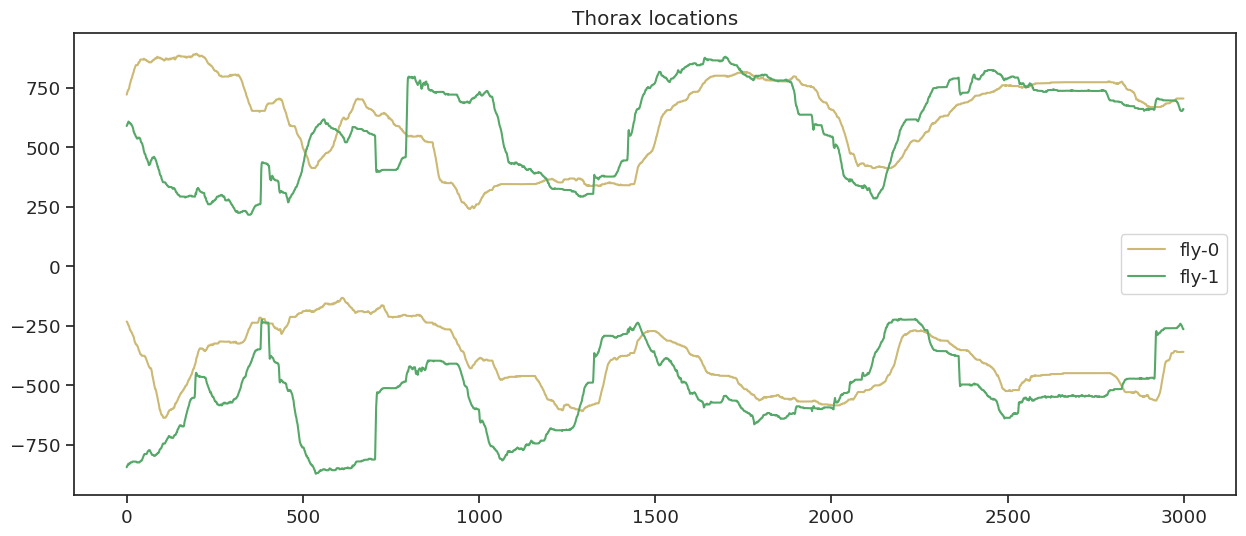

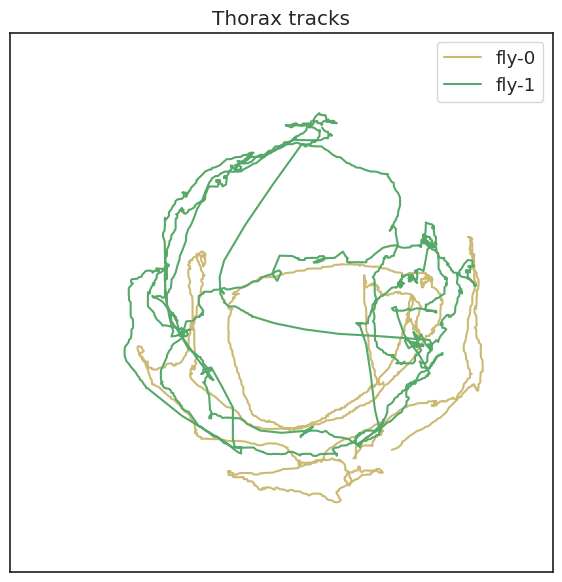

In [ ]:
# @title Visualize thorax movement across video
HEAD_INDEX = 0
THORAX_INDEX = 1
ABDO_INDEX = 2

head_loc = locations[:, HEAD_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]
abdo_loc = locations[:, ABDO_INDEX, :, :]

plt.figure()
plt.plot(thorax_loc[:,0,0], 'y',label='fly-0')
plt.plot(thorax_loc[:,0,1], 'g',label='fly-1')

plt.plot(-1*thorax_loc[:,1,0], 'y')
plt.plot(-1*thorax_loc[:,1,1], 'g')

plt.legend(loc="center right")
plt.title('Thorax locations')


plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0,0],thorax_loc[:,1,0], 'y',label='fly-0')
plt.plot(thorax_loc[:,0,1],thorax_loc[:,1,1], 'g',label='fly-1')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Thorax tracks')

In [ ]:
def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array

    win defines the window to smooth over

    poly defines the order of the polynomial
    to fit with

    """
    node_loc_vel = np.zeros_like(node_loc)

    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)

    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

Text(0.5, 1.0, 'Velocity')

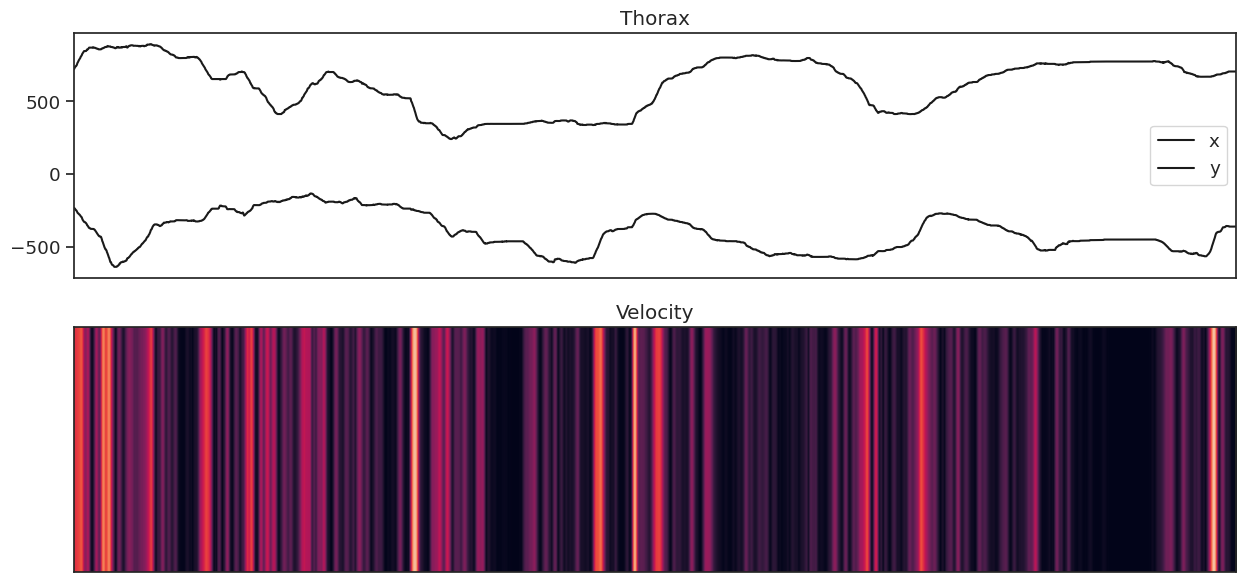

In [ ]:
# smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint
thx_vel_fly0 = smooth_diff(thorax_loc[:, :, 0])
thx_vel_fly1 = smooth_diff(thorax_loc[:, :, 1])

fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_fly0[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of fly speed')

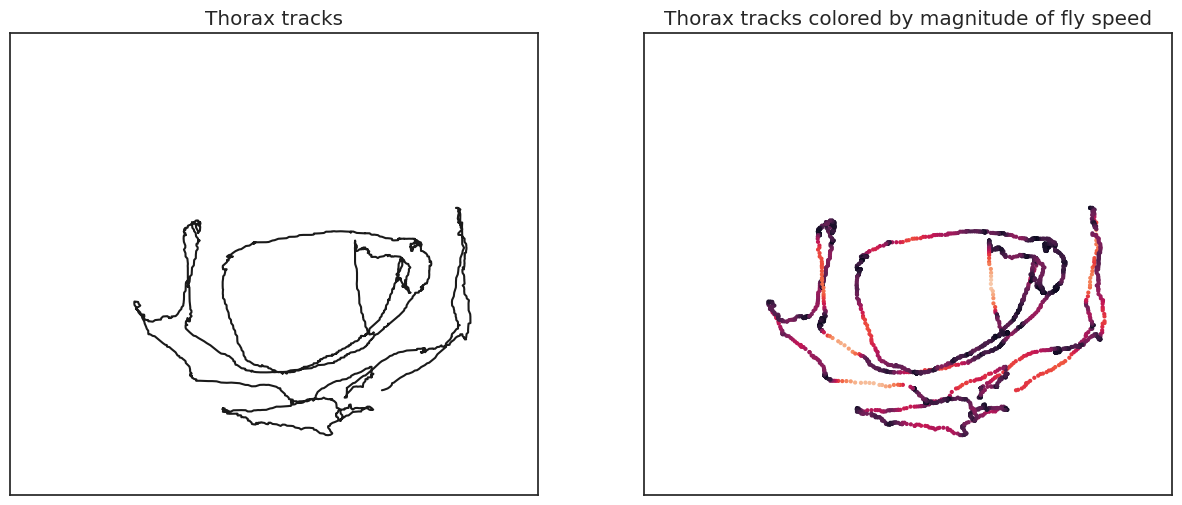

In [ ]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_fly0  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of fly speed')

In [ ]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between

    win sets the number of frames over which the covariance is computed

    """

    s1 = pd.Series(datax)
    s2 = pd.Series(datay)

    return np.array(s2.rolling(win).corr(s1))

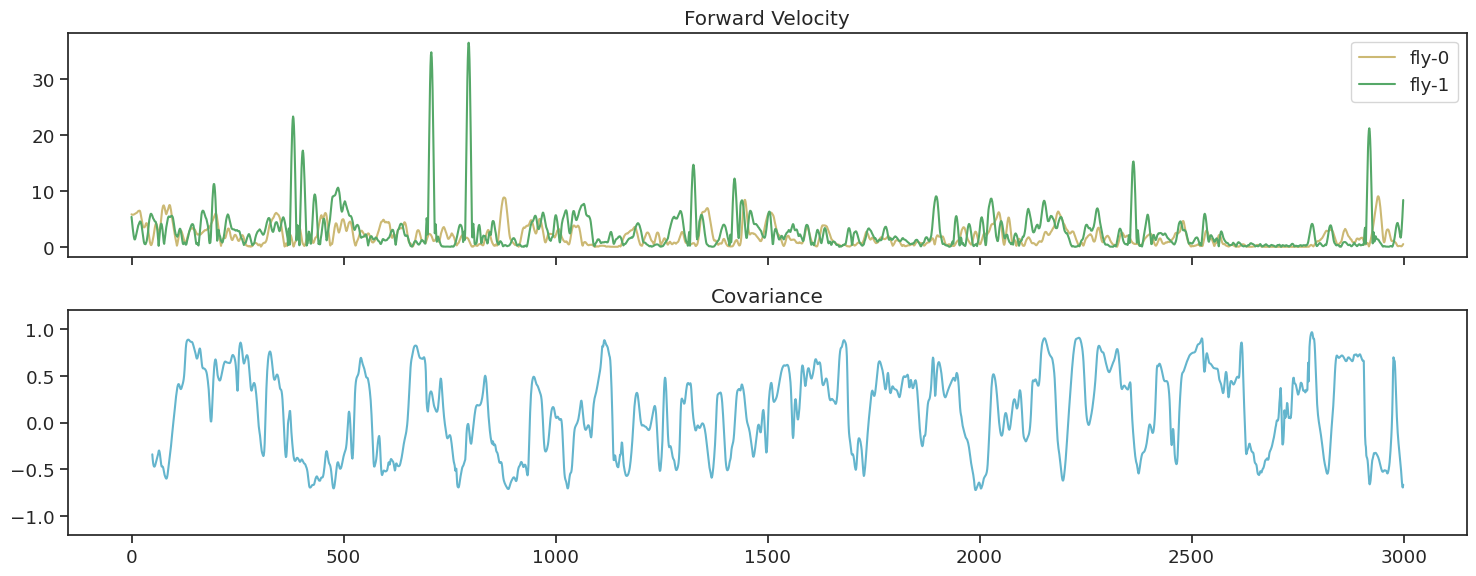

In [ ]:
win = 50

cov_vel = corr_roll(thx_vel_fly0, thx_vel_fly1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_fly0, 'y', label='fly-0')
ax[0].plot(thx_vel_fly1, 'g', label='fly-1')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

In [ ]:
def instance_node_velocities(instance_idx):
    fly_node_locations = locations[:, :, :, instance_idx]
    fly_node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[:, n, :])

    return fly_node_velocities

In [ ]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Fly {instance_idx} node velocities')

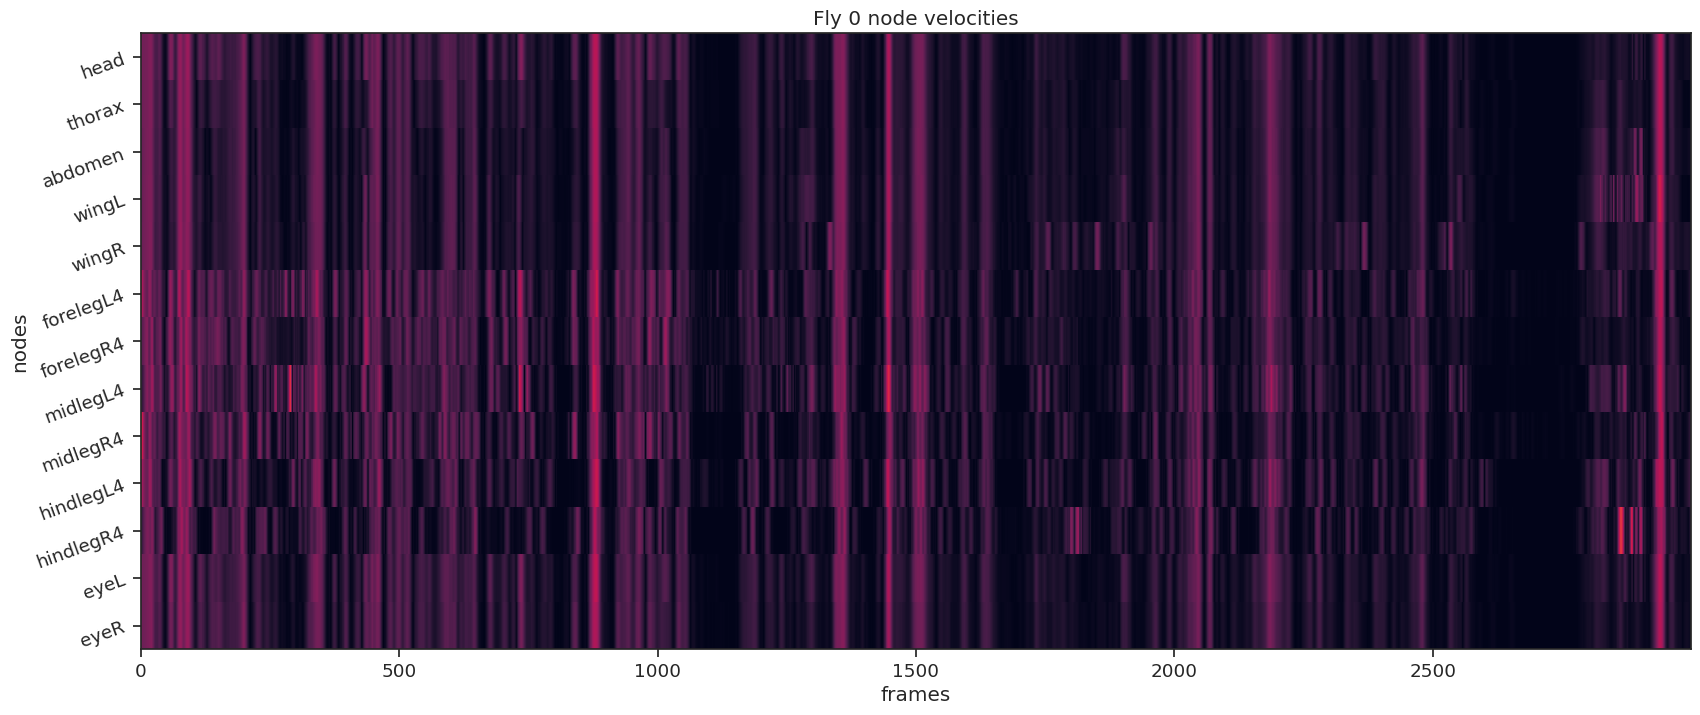

In [ ]:
fly_ID = 0
fly_node_velocities = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities)

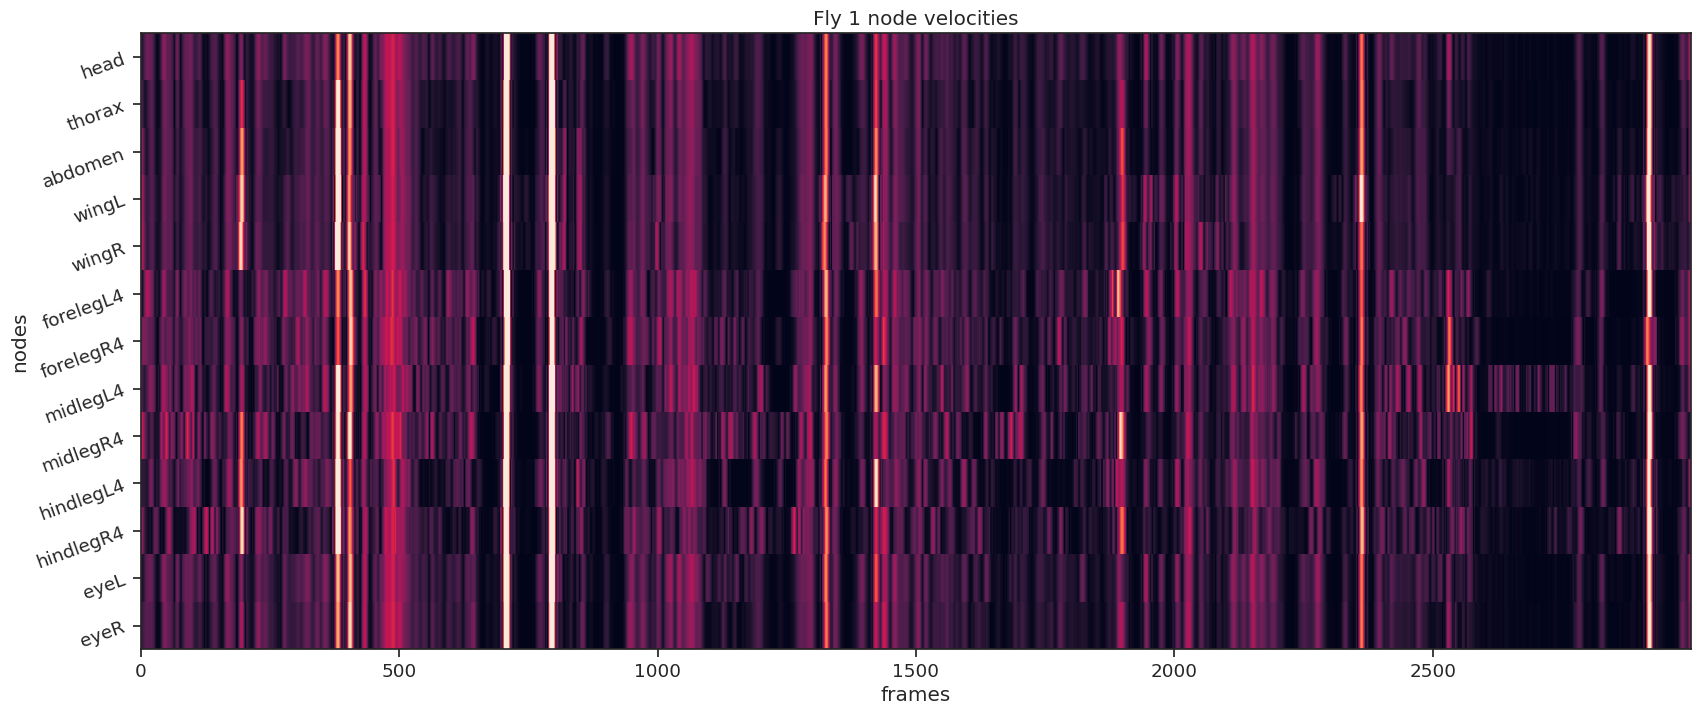

In [ ]:
fly_ID = 1
fly_node_velocities = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities)

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [ ]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(fly_node_velocities)

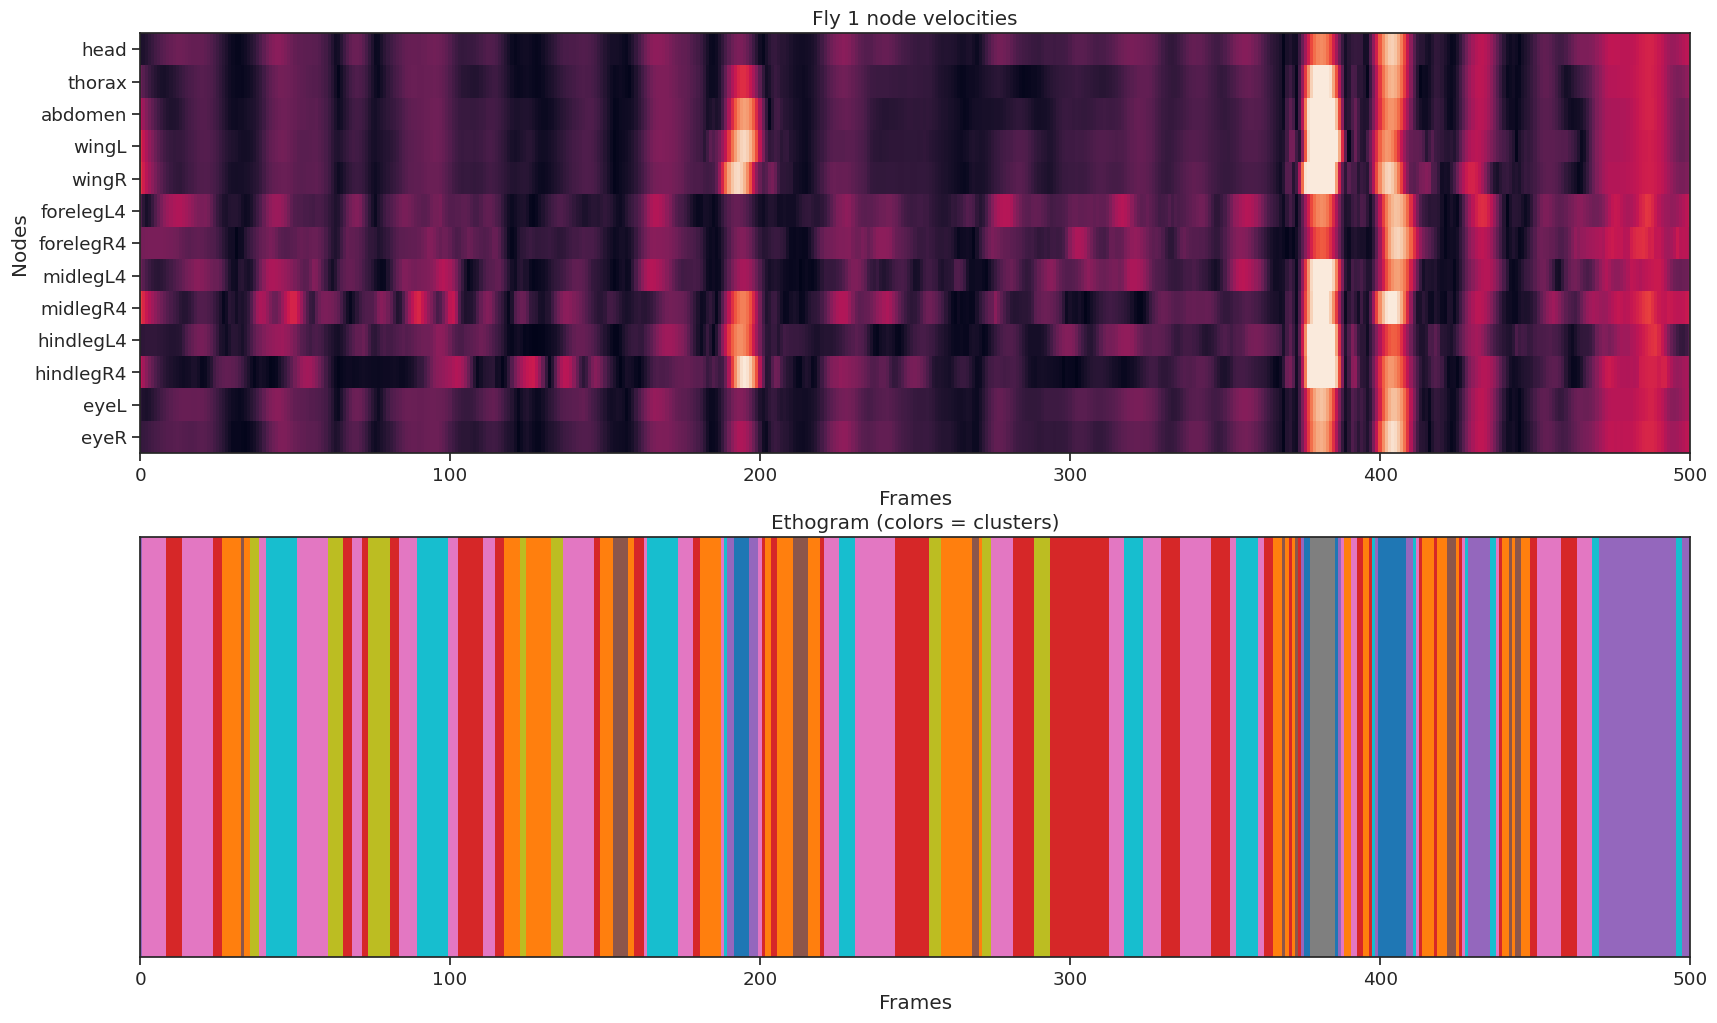

In [ ]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(fly_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Fly {fly_ID} node velocities")
ax1.set_xlim(0,500) #frame_count

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:576: RuntimeWarning: overflow encountered in cast
  knn_dists = knn_dists.astype(np.float32)


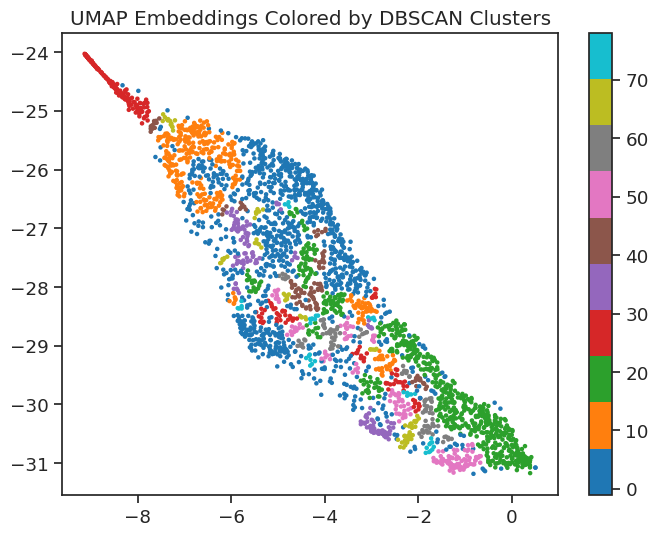

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
import umap
# For fly 1
fly_node_velocities = instance_node_velocities(fly_ID)
reducer = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.05, random_state=123, metric="mahalanobis")
embeddings = reducer.fit_transform(fly_node_velocities)

dbscan = DBSCAN(eps=0.1, min_samples=5)
labels_db = dbscan.fit_predict(embeddings)

# Visualize UMAP embeddings colored by DBSCAN clusters
plt.figure(figsize=(8,6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels_db, cmap='tab10', s=5)
plt.title('UMAP Embeddings Colored by DBSCAN Clusters')
plt.colorbar()
plt.show()

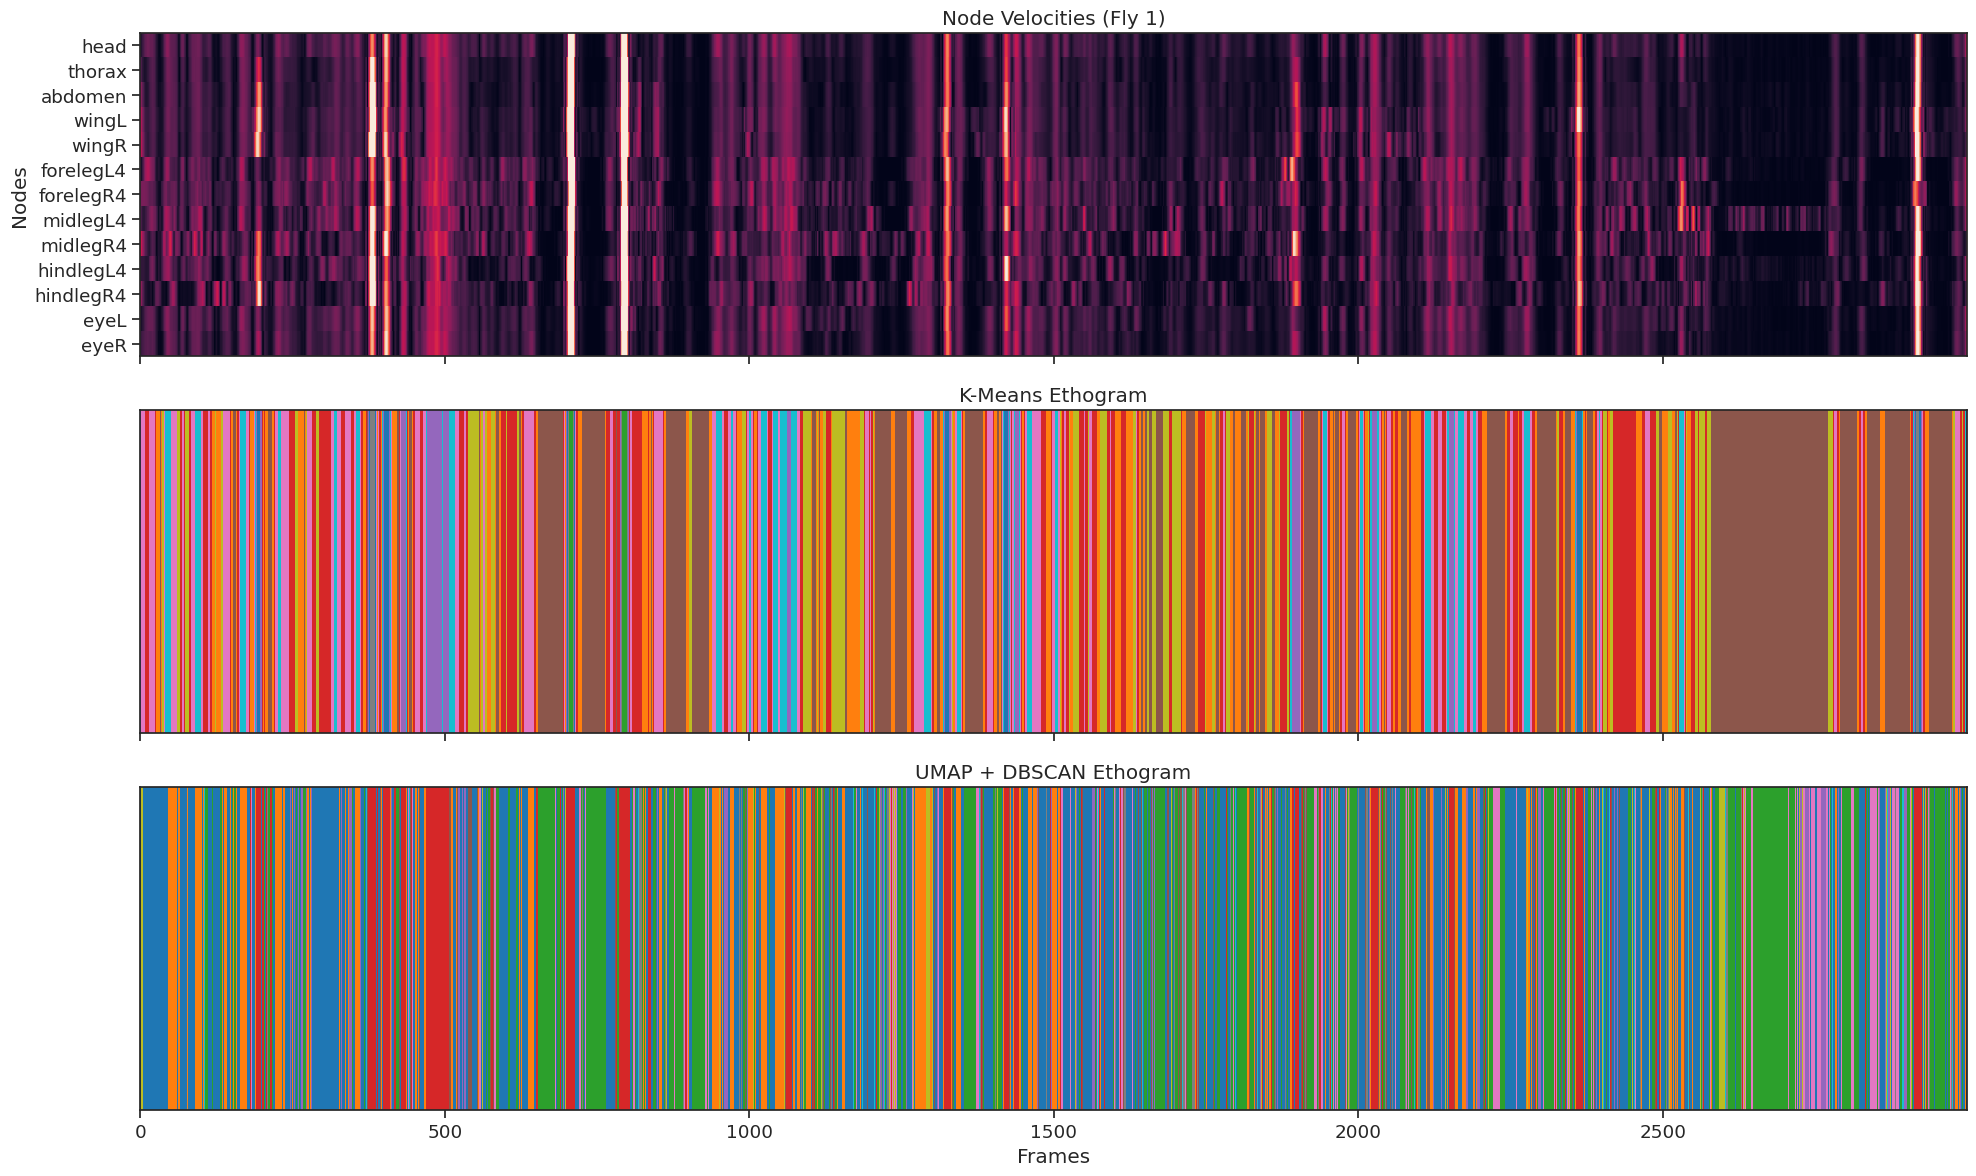

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

axs[0].imshow(fly_node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
axs[0].set_title('Node Velocities (Fly 1)')
axs[0].set_ylabel('Nodes')
axs[0].set_yticks(np.arange(node_count))
axs[0].set_yticklabels(node_names)

axs[1].imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
axs[1].set_title('K-Means Ethogram')
axs[1].set_yticks([])

# For DBSCAN, map -1 to a neutral color if needed (tab10 handles negative as gray)
axs[2].imshow(labels_db[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
axs[2].set_title('UMAP + DBSCAN Ethogram')
axs[2].set_yticks([])
axs[2].set_xlabel('Frames')

plt.tight_layout()
plt.show()